In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
def find_interval(x, x_data):
    left = 0
    rigth = len(x_data) - 1
    while rigth - left > 1:
        i = (rigth + left)//2
        if x < x_data[i]:
            rigth = i
        else:
            left = i
    return left

def lu_tridiagonal(c, d, e, b):
    n = len(d)

    for k in range(1, n):
        lam = c[k-1]/d[k-1]
        d[k] = d[k] - lam*e[k-1]
        c[k-1] = lam

    for k in range(1, n):
        b[k] = b[k] - c[k-1]*b[k-1]

    b[n-1] = b[n-1]/d[n-1]

    for k in range(n-2, -1, -1):
        b[k] = (b[k] - e[k]*b[k+1])/d[k]
    return b

### Coefficients
$s_k(x) = a_k + b_k(x - x_k) + c(x - x_k)^2 + d_k(x - x_k)^3, k = 0, 1, ...,n-1\\
h_k = x_{k+1} - x_k, k=0,...n-1\\
\beta_k=\frac{y_{k+1} - y_k}{h_k}, k=0,...n-1\\
v_k = 6(\beta_{k} - \beta_{k-1}),  k=1,...n-1$


## Natural cubic

In [3]:
def natural_cubic(x_data, y_data):
    """
    λ0 = 0 and λn = 0
    """
    n = len(x_data) - 1             # index of last point
    
    # coefficients
    h = np.zeros(n)
    h = x_data[1:n+1] - x_data[0:n]
    beta = (y_data[1:n+1] - y_data[0:n])/h
    v = 6*(beta[1:n] - beta[0:n-1]) # v[0]=6(β[1]-β[0)] 

    # tridiagonal system
    c = np.copy(h[1:n-1])
    d = 2*(h[0:n-1] + h[1:n])
    e = np.copy(h[1:n-1])

    # solution
    lam = np.zeros(n + 1)
    lam[1:n] = lu_tridiagonal(c, d, e, v)
    return lam

## Clamped cubic (Cúbica sujeta)

In [4]:
def clamped_cubic(x_data, y_data, ds0, dsn):
    """
    knows s'(x0) and s'(xn)
    """
    n = len(x_data) - 1             # index of last point

    # coefficients
    h = x_data[1:n+1] - x_data[0:n]
    beta = (y_data[1:n+1] - y_data[0:n])/h
    v = 6*(beta[1:n] - beta[0:n-1]) # v[0]=6(β[1]-β[0)]
   
    v[0] = v[0] - 3*(beta[0] - ds0)
    v[n-2] = v[n-2] - 3*(dsn - beta[n-1])
    
    # tridiagonal system
    d = np.zeros(n - 1)
    d[0] = 3/2*h[0] + 2*h[1]
    d[1:n-2] = 2*(h[1:n-2] + h[2:n-1])
    d[n-2] = 2*h[n-2] + 3/2*h[n-1]

    c = np.copy(h[1:n-1])
    e = np.copy(h[1:n-1])

    # solution
    lam = np.zeros(n + 1)
    lam[1:n] = lu_tridiagonal(c, d, e, v)

    lam[0] = 3/h[0]*(beta[0] - ds0) - lam[1]/2
    lam[n] = 3/h[n-1]*(dsn - beta[n-1]) - lam[n-1]/2
    return lam

## Parabolically terminated

In [5]:
def parabolically_terminated(x_data, y_data):
    """
    s"(x)=constant near extremes
    """
    n = len(x_data) - 1             # index of last point

    # coefficients
    h = x_data[1:n+1] - x_data[0:n]
    beta = (y_data[1:n+1] - y_data[0:n])/h
    v = 6*(beta[1:n] - beta[0:n-1]) # v[0]=6(β[1]-β[0)] 

    # tridiagonal system
    d = np.zeros(n - 1)
    d[0] = 3*h[0] + 2*h[1]
    d[1:n-2] = 2*(h[1:n-2] + h[2:n-1])
    d[n-2] = 2*h[n-2] + 3*h[n-1]

    c = np.copy(h[1:n-1])
    e = np.copy(h[1:n-1])

    # solution
    lam = np.zeros(n + 1)
    lam[1:n] = lu_tridiagonal(c, d, e, v)
    lam[0] = lam[1]
    lam[n] = lam[n-1]
    return lam

## Extrapolated

In [6]:
def extrapolated(x_data, y_data):
    """
    λ0 = λ0-h0(λ2-λ1)/h1 and λn = λ[n-1]+h[n-1](λ[n-1]-λ[n-2])/h[n-2] 
    """
    n = len(x_data) - 1          # index of last point

    # coefficients
    h = np.zeros(n + 1)
    h = x_data[1:n+1] - x_data[0:n]
    beta = (y_data[1:n+1] - y_data[0:n])/h
    v = 6*(beta[1:n] - beta[0:n-1]) # v[0]=6(β[1]-β[0)] 

    # tridiagonal system
    d = np.zeros(n - 1)
    d[0] = 3*h[0] + 2*h[1] + h[0]**2/h[1]
    d[1:n-2] = 2*(h[1:n-2] + h[2:n-1])
    d[n-2] = 2*h[n-2] + 3*h[n-1] + h[n-1]**2/h[n-2]

    e = np.zeros(n - 2)
    c = np.copy(h[1:n-1])
    e[1:] = c[1:]
    c[n-3] = h[n-2] - h[n-1]**2/h[n-2]
    e[0] = h[1] - h[0]*2/h[1]

    # solution
    lam = np.zeros(n + 1)
    lam[1:n] = lu_tridiagonal(c, d, e, v)
    lam[0] = lam[1] - h[0]*(lam[2] - lam[1])/h[1]
    lam[n] = lam[n-1] + h[n-1]*(lam[n-1] - lam[n-2])/h[n-2]
    return lam

## Curvature in extremes

In [7]:
def curvature_in_extremes(x_data, y_data, dds0, ddsn):
    """
    λ0 = s"(x0) and λn = s"(xn)
    """
    n = len(x_data) - 1             # index of last point
    
    # coefficients
    h = x_data[1:n+1] - x_data[0:n]
    beta = (y_data[1:n+1] - y_data[0:n])/h
    v = 6*(beta[1:n] - beta[0:n-1]) # v[0]=6(β[1]-β[0)] 
    v[0] = v[0] - h[0]*dds0
    v[n-2] = v[n-2] - h[n-1]*ddsn

    # tridiagonal system
    c = np.copy(h[1:n-1])
    d = 2*(h[0:n-1] + h[1:n])
    e = np.copy(h[1:n-1])
    
    # solution
    lam = np.zeros(n + 1)
    lam[0] = dds0
    lam[1:n] = lu_tridiagonal(c, d, e, v)
    lam[n] = ddsn
    return lam

## Cubic Spline

In [8]:
def cubic_spline(x, x_data, y_data, lam):
    k = find_interval(x, x_data)

    h = x_data[k+1] - x_data[k]
    beta = (y_data[k+1] - y_data[k])/h

    a = y_data[k]
    b = beta - h/6*(2*lam[k] + lam[k+1])
    c = lam[k]/2
    d = (lam[k+1] - lam[k])/(6*h)

    return a + b*(x - x_data[k]) + c*(x - x_data[k])**2 + d*(x - x_data[k])**3

def get_polynomial(x, x_val, x_data, y_data, lam):
    k = find_interval(x_val, x_data)

    h = x_data[k+1] - x_data[k]
    betta = (y_data[k+1] - y_data[k])/h

    a = y_data[k]
    b = betta - h/6*(2*lam[k] + lam[k+1])
    c = lam[k]/2
    d = (lam[k+1] - lam[k])/(6*h)
    
    return a + b*(x - x_data[k]) + c*(x - x_data[k])**2 + d*(x - x_data[k])**3

### Práctica Calificada 2, Pregunta 1

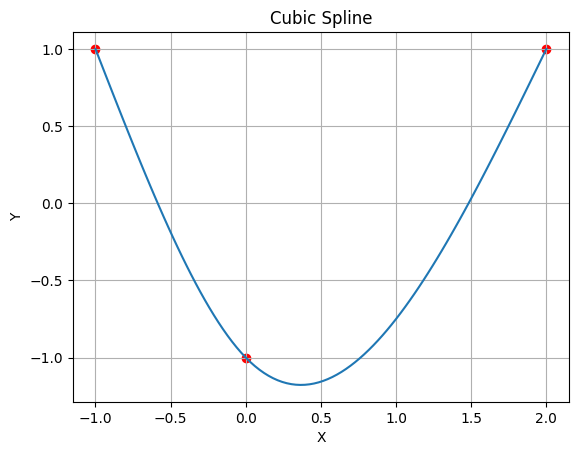

In [9]:
# Plot
x_data = np.array([-1,0,2])
y_data = np.array([1,-1,1])

#change wether it's natural or clamped
lam = natural_cubic(x_data, y_data)
n = len(x_data) - 1

x_domain = np.linspace(x_data[0], x_data[n], 100)
y_image = [cubic_spline(i, x_data, y_data, lam) for i in x_domain]

plt.title("Cubic Spline")
plt.grid(True)
plt.scatter(x_data, y_data, c='r')
plt.plot(x_domain, y_image)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [10]:
# Polynomial
x = sp.symbols('x')
for k in range(n):
    p = get_polynomial(x, x_data[k], x_data, y_data, lam)
    print(f"S_{k}(x) =", sp.latex(sp.N(p.expand(p), 6)))
# muestra los polinomio cubico de cada intervalo problema anterior 

S_0(x) = 0.5 x^{3} + 1.5 x^{2} - 1.0 x - 1.0
S_1(x) = - 0.25 x^{3} + 1.5 x^{2} - 1.0 x - 1.0


### Práctica Calificada 2, Pregunta 2

In [11]:
def lagrange(x, x_data, y_data):
    """
    Return the interpolation polynomial
    """
    n = len(x_data)
    q = 0
    for k in range(n):
        p = 1
        for j in range(n):
            if k != j:
                p *= (x - x_data[j])/(x_data[k] - x_data[j])
        q += y_data[k]*p
    return q

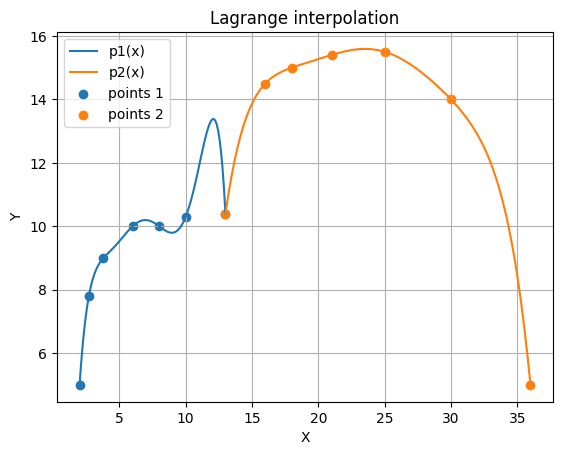

In [12]:
x_data1 = [2, 2.7, 3.8, 6, 8, 10, 13]
y_data1 = [5, 7.8, 9, 10.0, 10.0, 10.3, 10.4]

x_data2 = [13, 16, 18, 21, 25, 30, 36]
y_data2 = [10.4, 14.5, 15, 15.4, 15.5, 14, 5]

x = sp.symbols('x')
p1 = sp.expand(lagrange(x, x_data1, y_data1))
p2 = sp.expand(lagrange(x, x_data2, y_data2))

x_interval1 = np.linspace(x_data1[0], x_data1[-1], 100)
x_interval2 = np.linspace(x_data2[0], x_data2[-1], 100)

plt.plot(x_interval1, [p1.subs(x, i) for i in x_interval1])
plt.plot(x_interval2, [p2.subs(x, i) for i in x_interval2])
plt.scatter(x_data1, y_data1)
plt.scatter(x_data2, y_data2)
plt.grid(True)
plt.title("Lagrange interpolation")
plt.legend(("p1(x)","p2(x)", "points 1", "points 2"))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Práctica Calificada 2, Pregunta 3

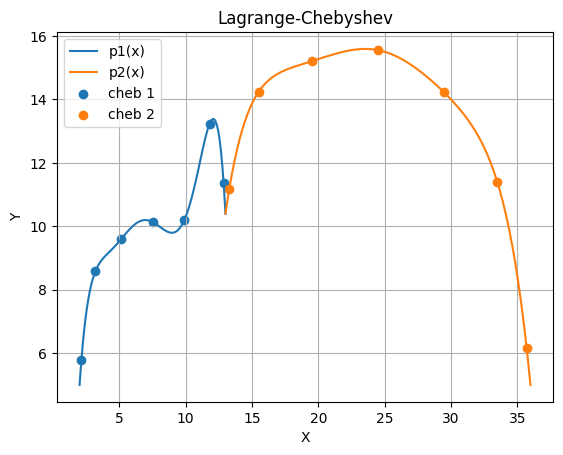

In [13]:
a, b = x_data1[0], x_data1[-1]
n = 6  # index of last node
x_cheb_nodes1 = [(b+a)/2 + (b-a)/2*np.cos((k+0.5)/(n+1)*np.pi) for k in range(n+1)]

a, b = x_data2[0], x_data2[-1]
n = 6 
x_cheb_nodes2 = [(b+a)/2 + (b-a)/2*np.cos((k+0.5)/(n+1)*np.pi) for k in range(n+1)]

plt.plot(x_interval1, [p1.subs(x, i) for i in x_interval1])
plt.plot(x_interval2, [p2.subs(x, i) for i in x_interval2])
plt.scatter(x_cheb_nodes1, [p1.subs(x, i) for i in x_cheb_nodes1])
plt.scatter(x_cheb_nodes2, [p2.subs(x, i) for i in x_cheb_nodes2])
plt.grid(True)
plt.title("Lagrange-Chebyshev")
plt.legend(("p1(x)","p2(x)", "cheb 1", "cheb 2"))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Examen Parcial, pregunta 3

S_0(x) = 0.05633802817*x**3 - 1.056338028*x + 8.0
S_1(x) = 0.2816901408*x**3 - 0.676056338*x**2 - 0.3802816901*x + 7.774647887
S_2(x) = -0.9577464789*x**3 + 8.61971831*x**2 - 23.61971831*x + 27.14084507
S_0(x) = 10.90355624*x**3 - 16.35533436*x**2 + 5.241524932*x + 1.605126595
S_1(x) = -1.728111712*x**3 + 10.17116834*x**2 - 13.32702696*x + 5.937788703
S_2(x) = -2.605929054*x**3 + 14.12134638*x**2 - 19.25229401*x + 8.90042223
S_3(x) = 12.94742946*x**3 - 116.5268651*x**2 + 346.5626981*x - 332.5269037
S_0(x) = -3.566930551*x**3 + 5.350395826*x**2 - 0.0325206909*x + 0.6245277078
S_1(x) = 0.4363080245*x**3 - 3.056405182*x**2 + 5.852240014*x - 0.7485831234
S_2(x) = -1.016552717*x**3 + 12.1986326*x**2 - 47.54039223*x + 61.54282116


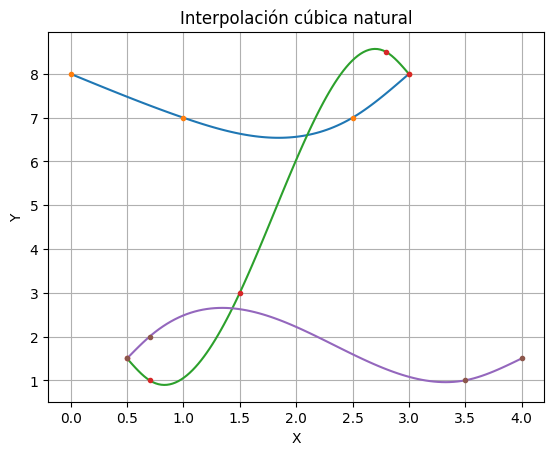

In [14]:
data = [np.array([[0, 1, 2.5, 3], [8, 7, 7, 8]]),
        np.array([[0.5, 0.7, 1.5, 2.8, 3], [1.5, 1, 3, 8.5, 8]]),
        np.array([[0.5, 0.7, 3.5, 4], [1.5, 2, 1, 1.5]])]
     
(x, y) = (0, 1)
x_s = sp.symbols('x')

for axis in data:
    lam = natural_cubic(axis[x], axis[y])
    for k in range(len(axis[x]) - 1):
        p = get_polynomial(x_s, axis[x][k], axis[x], axis[y], lam)
        print(f"S_{k}(x) =", sp.N(sp.expand(p), 10))

    x_interval = np.linspace(axis[x][0], axis[x][-1], 100)
    y_interval = [cubic_spline(i, axis[x], axis[y], lam) for i in x_interval]
    plt.plot(x_interval, y_interval) 
    plt.plot(axis[x], axis[y], '.')
plt.title("Interpolación cúbica natural")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Práctica Dirigida 2, problema 18

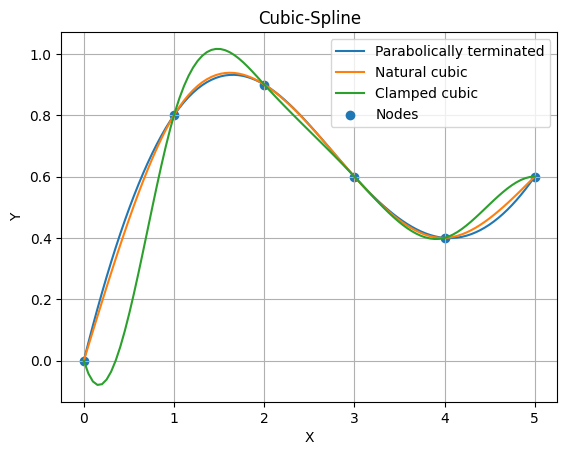

In [15]:
x_data = np.array([0, 1, 2, 3.0, 4, 5])
y_data = np.array([0, 0.8, 0.9, 0.6, 0.4, 0.6])

lam_p = parabolically_terminated(x_data, y_data)
lam_n = natural_cubic(x_data, y_data)
lam_c = clamped_cubic(x_data, y_data, ds0=-1, dsn=0)

x_interval = np.linspace(x_data[0], x_data[-1], 100)
y_parabollic = [cubic_spline(i, x_data, y_data, lam_p) for i in x_interval]
y_natural = [cubic_spline(i, x_data, y_data, lam_n) for i in x_interval]
y_clamped = [cubic_spline(i, x_data, y_data, lam_c) for i in x_interval]

plt.plot(x_interval, y_parabollic)
plt.plot(x_interval, y_natural)
plt.plot(x_interval, y_clamped)
plt.scatter(x_data, y_data)
plt.grid(True)
plt.title("Cubic-Spline")
plt.legend(('Parabolically terminated', 'Natural cubic', 'Clamped cubic', 'Nodes'))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Práctica Dirigida 2, problema 5

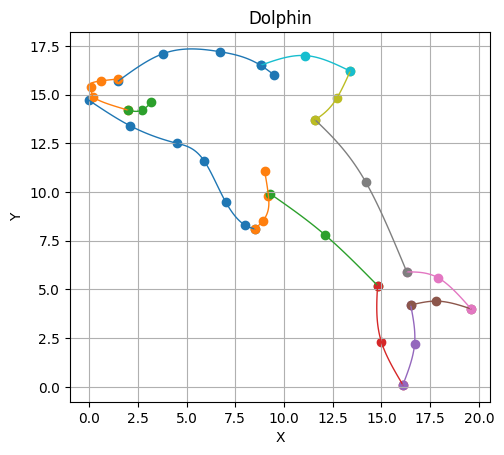

In [16]:
data = [np.array([[0.0, 2.1, 4.5, 5.9, 7.0, 8.0, 8.5], [14.7, 13.4, 12.5, 11.6, 9.5, 8.3, 8.1]]),
        np.array([[9.0, 9.2, 8.9, 8.5], [11.1, 9.8, 8.5, 8.1]]),
        np.array([[9.3, 12.1, 14.8], [9.9, 7.8, 5.2]]),
        np.array([[14.8, 15.0, 16.1], [5.2, 2.3, 0.1]]),
        np.array([[16.5, 16.7, 16.1], [4.2, 2.2, 0.1]]),
        np.array([[17.8, 16.5, 19.6], [4.4, 4.2, 4.0]]),
        np.array([[16.3, 17.9, 19.6], [5.9, 5.6, 4.0]]),
        np.array([[11.6, 14.2, 16.3], [13.7, 10.5, 5.9]]),
        np.array([[13.4, 12.7, 11.6], [16.2, 14.8, 13.7]]),
        np.array([[11.1, 8.8, 13.4], [17.0, 16.5, 16.2]]),
        np.array([[6.7, 3.8, 8.8, 9.5, 1.5], [17.2, 17.1, 16.5, 16.0, 15.7]]),
        np.array([[0.6, 1.5, 0.1, 0.2, 2.0], [15.7, 15.8, 15.4, 14.9, 14.2]]),
        np.array([[3.2, 2.0, 2.7], [14.6, 14.2, 14.2]])]

# indica cuales datos es mejor hallar su inversa
inverse = [False, True, False, True, True, False, 
           False, False, False, False, False, True, False]
(x, y) = (0, 1)
i = 0
for axis in data:
    n = len(axis[x]) - 1

    # invierte la relacion (puntos)
    if inverse[i]:
        (x, y) = (1, 0)
    else:
        (x, y) = (0, 1)

    # ordena de x de menor a mayor
    sort_index = np.argsort(axis[x])
    x_data = axis[x][sort_index]
    y_data = axis[y][sort_index]

    lam = natural_cubic(x_data, y_data)

    x_domain = np.linspace(x_data[0], x_data[n], 100)
    y_image = [cubic_spline(j, x_data, y_data, lam) for j in x_domain]

    # la funcion es nuevamente invertida para obtener su grafica correspondiente
    if inverse[i]:
        plt.plot(y_image, x_domain, linewidth=1.0)
        plt.scatter(y_data, x_data)
    else:
        plt.plot(x_domain, y_image, linewidth=1.0) 
        plt.scatter(x_data, y_data)
    plt.axis('scaled')
    i += 1
plt.title("Dolphin")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()